First import all the relevant scripts

In [2]:
#general
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#for the data
import generate_data as generator

#for the network
from feedforward_ANN.cifar10_utils import get_cifar10_raw_data, preprocess_cifar10_data
from feedforward_ANN.cifar10_utils import transform_label_encoding_to_one_hot
from feedforward_ANN.layer import LinearLayer, ReLuLayer, TanHLayer
from feedforward_ANN.network import Network
from feedforward_ANN.train import SGD
from feedforward_ANN.loss import SoftmaxCrossEntropyLoss
from feedforward_ANN.score import get_accuracy as get_accuracy


In [4]:
#data parameters
grid_len, grid_width = 16, 16
train_size = 10000
validation_size = 5000
test_size = 1000

params = {
    "size_square_li" : [4, 4.5, 5, 5.5, 6],
    "radius_circle_li" : [2.5, 3, 3.5, 4],
    "length_rectangle_li" : [5.5, 6, 6.5, 7, 7.5],
    "width_rectangle_li" : [2.5, 3, 3.5, 4, 4.5],
    "rotation_li_rectangle" : [0, 45, 90, 135],
    "rotation_li_square" : [0, 45],
    "distance_border" : 2.5
}

gen = generator.GenerateData(grid_len, grid_width, add_noise=False, params=params)
    
gen = generator.GenerateData(grid_len, grid_width, params=params)

X_train, y_train = gen.generate_batch_samples(batch_size=train_size)
X_val, y_val = gen.generate_batch_samples(batch_size=validation_size)
X_test, y_test = gen.generate_batch_samples(batch_size=test_size)

num_classes = y_train[0].shape[0]
#N = X_train[0].shape[0]
number_of_input_pixels = X_train[0].shape[0] 

print(num_classes)

3


In [5]:
# Default parameters. 
num_iterations = 100
val_iteration = 50
batch_size = 150
weight_decay = 0
num_hidden_units = [75, 20]
learning_rate_li = [0.005, 0.003, 0.0015]

#"weight_factor": .2/np.sqrt(number_of_input_pixels), 
params_lin_layer_li = [
    {
        "weight_factor": 0.001, 
        "bias_value": 0.001,
        "learning_rate": 0.05
    },
    {
        "weight_factor": 0.001,
        "bias_value":0.001,
        "learning_rate": 0.03
    },
    {
        "weight_factor": 0.001,
        "bias_value": 0.001,
        "learning_rate": 0.02
    }
]

print(params_lin_layer_li)

network = Network(batch_size, weight_decay, train_mode=True)
network.add_layer(
    'linear', dim_out=num_hidden_units[0], 
    input_dim=number_of_input_pixels, params=params_lin_layer_li[0]
)
network.add_layer('relu')
network.add_layer('linear', dim_out=num_hidden_units[1], 
                  params=params_lin_layer_li[1])
network.add_layer('relu')
network.add_layer('linear', dim_out=num_classes, 
                  params=params_lin_layer_li[2])
network.add_loss(SoftmaxCrossEntropyLoss())


[{'learning_rate': 0.05, 'bias_value': 0.001, 'weight_factor': 0.001}, {'learning_rate': 0.03, 'bias_value': 0.001, 'weight_factor': 0.001}, {'learning_rate': 0.02, 'bias_value': 0.001, 'weight_factor': 0.001}]


starting validation accuracy 0.3288


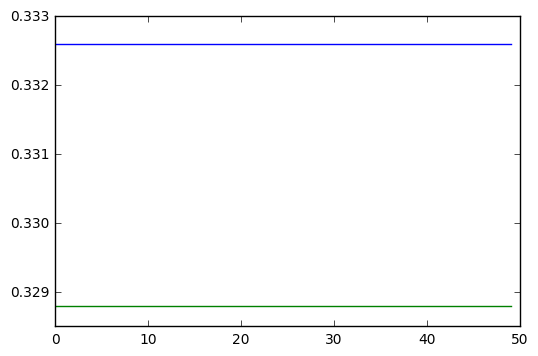

the final accuracy on the validation set is 0.3288


In [6]:
sgd = SGD(network, X_train, y_train, batch_size)

decay_rate = 1
print("starting validation accuracy {}".format(
    get_accuracy(network, X_val, np.argmax(y_val, 1))
))
validation_accuracy_li = []
train_accuracy_li = []
for i in range(50):
    if i%10==0 and i != 0:
        decay_rate = 1
    else:
        decay_rate = 1
    sgd.train(num_iterations, decay_rate, False)
    train_accuracy = get_accuracy(network, X_train, np.argmax(y_train, 1))
    #print("the training accuracy is {}".format(train_accuracy))
    train_accuracy_li.append(train_accuracy)
    val_accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
    #print("the validation accuracy is {}".format(val_accuracy))
    validation_accuracy_li.append(val_accuracy)

plt.plot(train_accuracy_li)
plt.plot(validation_accuracy_li)
plt.show()

accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
print("the final accuracy on the validation set is {}".format(accuracy))

In [ ]:

def get_random_network():
    network = Network(batch_size, weight_decay, train_mode=True)
    network.add_layer('linear', output_dim=num_hidden_units[0],
                      input_dim=number_of_input_pixels,
                      params=params_lin_layer)
    network.add_layer('relu')
    network.add_layer('linear', num_hidden_units[1], 
                      params=params_lin_layer)
    network.add_layer('relu')
    network.add_layer('linear', num_classes, params=params_lin_layer)
    network.add_loss(SoftmaxCrossEntropyLoss())
    
    return network

def get_trained_network():
    network = get_random_network()
    sgd = SGD(network, X_train, y_train, batch_size)
    for i in range(10):
        sgd.train(num_iterations, learning_rate, False)
        val_accuracy = get_accuracy(network, X_val, np.argmax(y_val, 1))
        print("the validation accuracy is {}".format(val_accuracy))
        if val_accuracy > 0.45:
            break
            
    return network


First, import functions to calculuate information theory measures. 

In [ ]:
from information_theory.info_theory import calculate_mutual_information
from information_theory.info_theory import points_to_dist

In [ ]:
def one_hot_to_number(vec):
    return np.argmax(vec, axis=1)

def create_distributions(X, out, batch_size, max_amount_variables):
    """compute the average mutual information between input and ouput
    
    note: the amount of input pixels used is variable  
    """
    
    num_pictures = X.shape[0]
    unique_out, counts_out = np.unique(out, return_counts=True)
    out_dist = counts_out/np.sum(counts_out)
    mutual_info_dict = {}
    
    for i in range(1, max_amount_variables):
        pixel_arr = np.zeros((num_pictures, i))
        pixel_plus_outcome_arr = np.zeros((num_pictures, i+1))
        pixel_plus_outcome_arr[:, -1:] = np.transpose(np.array([out]))
        mutual_info_li = []
        for batch_number in range(batch_size):
            position_points = np.random.randint(grid_len*grid_width, size=i)  
            pixel_arr = X[:, position_points]
            pixel_plus_outcome_arr[:, :-1] = pixel_arr
            
            pixel_dist = points_to_dist(pixel_arr)
            mutual_dist = points_to_dist(pixel_plus_outcome_arr)
            
            mutual_info = calculate_mutual_information(pixel_dist, out_dist, mutual_dist)
            mutual_info_li.append(mutual_info)
            
        mutual_info_dict[i] = mutual_info_li
        
    return mutual_info_dict

def get_output_network(network, X, shape_output, number_of_batches):
    out_one_hot = np.zeros((shape_output))
    batch_size = network.batch_size
    for i in range(number_of_batches):
        out_one_hot[i*batch_size:(i+1)*batch_size] = (
            network.forward(X[i*batch_size:(i+1)*batch_size]) 
        )
    return one_hot_to_number(out_one_hot)
    
def get_mutual_info_network(get_network, number_of_batches=50, max_amount_variables=10):
    gen = generator.GenerateData(grid_len, grid_width, add_noise=False, params=None)
    X, y = gen.generate_batch_samples(batch_size=number_of_batches*batch_size)
    
    batch_size_sampling_distributions = 100
    plot_data = []
    for i in range(10):
        out = get_output_network(get_network(), X, y.shape, number_of_batches)
        mutual_info_dict = create_distributions(X, out, batch_size_sampling_distributions, max_amount_variables)
        plot_data.append([np.mean(v) for k, v in mutual_info_dict.items()])
        #for k, v in mutual_info_dict.items():
        #    print("number of variables {}, mean mutual info {}".format(k, np.mean(v)))

    return plot_data



In [ ]:

print("get a random network")
plot_data_random_network = get_mutual_info_network(get_random_network)

print("get a trained network")
plot_data_trained_network = get_mutual_info_network(get_trained_network)

plot_data_actual_values = []
for i in range(10):
    out = one_hot_to_number(out_one_hot)
    mutual_info_dict = create_distributions(X, out, batch_size=30, max_amount_variables=10)
    plot_data_actual_values.append([np.mean(v) for k, v in mutual_info_dict.items()])




In [ ]:
#smarter way to calculate mutual information

prob_y_hat = {
    1: None,
    2: None,
    3: None
}

prob_y_given_y_hat = {
    (1,1) : None,
    (1,2) : None,
    (1,3) : None,
    (2,1) : None,
    (2,2) : None,
    (2,3) : None,
    (3,1) : None,
    (3,2) : None,
    (3,3) : None,
}

def get_prob(network, pos_pixels, value_pixels, y, y_hat):
    #from all pictures select those where y, y_hat match
    sel_pictures = [picture for picture in pictures[y] 
                    if network.calculate_forward(picture) == y_hat]

    #from those pictures calculate what percentage has 
    #the values of the pixels at the right positions
    if sel_pictures == []:
        return 0
    else:
        return sum(
            [1 for picture in sel_pictures if picture[pos_pixels] == value_pixels]
        )/len(sel_pictures)

def calculate_probability(network, pos_pixels, value_pixels):
    #calculate P(x|y_hat) for every value of y_hat 
    #x represents the value of certain pixels and y_hat the output of the ANN
    
    prob_li = []
    for y_hat in range(num_classes):
        #calculate p(y|y_hat) and p(y_hat) upfront 
        #prob = sum_y (p(x|y, y_hat) * p(y|y_hat) * p(y_hat))
        prob = 0
        for y in range(num_classes):
            prob = prob + (
                get_prob(network, pos_pixels, value_pixels, y, y_hat) *
                prob_y_given_y_hat[(y, y_hat)] *
                prob_y_hat[y_hat]
            )
        prob_li.append(prob)
        
    return prob_li
    
def calculate_mutual_info_input_output(network, size_input_network, max_number_input_pixels, 
                                       sample_size_positions, sample_size_values):
    for pixels in range(max_number_input_pixels):
        for sample_pos in range(sample_size_positions):
            #select position of pixels at random
            position_pixels = np.random.randint(size_input_network, pixels)
            for i in range(sample_size_values):
                #choose values of position at random from all possible values
                rand_picture = all_pictures[np.random.randint(all_pictures.shape[0])]
                value_pixels = rand_picture[position_pixels]
                #calculate P(x, y_hat),
                #where x represents the values at certain positions (chosen above) 
                #and y_hat is the outcome of the network
                prob = calculate_probability(network, pos_pixels, value_pixels)
                
            #using the calculated distributions calculate the mutual information
        
    

In [ ]:
plt.legend(loc=2,prop={'size':6})
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20

plot_data = np.arange(0, 9, 1)
plot_trained_network_mean = np.mean(np.array(plot_data_trained_network), axis=0)
plot_trained_network_std = np.std(np.array(plot_data_trained_network), axis=0)
lower_bound_trained_network = plot_trained_network_mean-plot_trained_network_std 
upper_bound_trained_network = plot_trained_network_mean+plot_trained_network_std

plot_random_network_mean = np.mean(np.array(plot_data_random_network), axis=0)
plot_random_network_std = np.std(np.array(plot_data_random_network), axis=0)
lower_bound_random_network = plot_random_network_mean-plot_random_network_std
upper_bound_random_network = plot_random_network_mean+plot_random_network_std 

plot_actual_values_mean = np.mean(np.array(plot_data_actual_values), axis=0)
plot_actual_values_std = np.std(np.array(plot_data_actual_values), axis=0)

plt.plot(plot_trained_network_mean, label="mean trained network")
plt.fill_between(plot_data, lower_bound_trained_network, 
                 upper_bound_trained_network, alpha=0.3)

plt.plot(plot_random_network_mean, label="mean random network")
plt.fill_between(plot_data, lower_bound_random_network, 
                 upper_bound_random_network, alpha=0.3)

plt.plot(plot_actual_values_mean, label="mean actual outputs")
#plt.fill_between(plot_data, 
#                 plot_actual_values_mean-plot_actual_values_std,
#                 plot_random_network_mean+plot_actual_values_std,
#                 alpha=0.3)

plt.title("Mutual information between randomly selected pixels and network output")
plt.xlabel("number of variables")
plt.ylabel("mean mutual information between pixels and output network")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

a = pd.DataFrame(np.array([[1,2,1],[1,2,2],[1,2,1], [1,1,1], [1,2,2], [2,1,2]]))
print("a equals")
print(list(a.columns))

b = a.groupby([0,1,2])
c = pd.DataFrame(b.size()).values.flatten()
print("c equals")
print(c)

d = c/c.sum()
print(d)
print(d.values)